# Clean version of the auditory debug ntbk

# Testing updated JRA match list

In [1]:
import mne
import logging
import mne_bids
import pandas as pd
import numpy as np
from scipy.io import wavfile
from jra_utils import approx_match_samples

from pathlib import Path
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)

#path = Path("/home/co/data/neuralset/LPP_copy/pallierlisten2023/download")
path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

def testing(subject, run_id, n_missing=5, abs_tol=10):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    triggers = mne.find_stim_steps(raw, stim_channel="STI008")
    # Offsets
    triggers = triggers[triggers[:, 2] == 0]

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Remove the empty words:

    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    # word_triggers = triggers[triggers[:, 2] > 1]
    word_triggers = triggers
    try:
        i, j = approx_match_samples((words.start * 1000).tolist()[:], word_triggers[:, 0], abs_tol=abs_tol, max_missing=n_missing)
        return f"Worked for {subject} {run_id}, {len(i) / words.start.shape[0]}"
    except Exception as e:
        # When it doesn't work, print the index where it broke, and create a new file from it
        # To add to the tests
        print(f"Failed for {subject} {run_id}")
        print(f"Error message: {str(e)}")

In [2]:
from jra_utils import TOL_MISSING_DICT

total_subjects = 24
worked = 0
n_missing = 5
for subject in range(21,total_subjects+1):
    for run in range(6,10):
        run_id = '0' + str(run)
        subject = str(subject)

        # Get the TOL AND MISSING
        abs_tol, max_missing = TOL_MISSING_DICT.get((int(subject), run), (10, 5))
        print(f"Testing for {subject} {run_id} with {max_missing} missing and {abs_tol} abs_tol")
        result = testing(subject, run_id, n_missing=max_missing, abs_tol=abs_tol)
        try:
            if "Worked" in result:
                print(f"{result}")
                worked += 1
        except Exception as e:
            print(f"Failed for {subject} {run_id}")
            print(e)
            continue

print(f"Worked for {worked} out of {total_subjects * 9} subjects: {worked / total_subjects * 100 * 9} ")

Testing for 21 06 with 5 missing and 30 abs_tol
Failed for 21 06
Error message: Failed to match after indices [1001, 1000] (values {[s.last_value for s in seqs]}, {first_match=})
(follows:
 [   0.  190.  540.  600.  950. 1050. 2020. 2180. 2580. 4970.]
 [   0  141  332  683  743 1093 1193 2163 2324 2725](before:
 [-3370. -2980. -2850. -1780. -1680.  -970.  -850.  -780.  -600.  -140.]
 [-3383 -3343 -2951 -2821 -1644 -1544  -832  -712  -642  -461]
Failed for 21 06
argument of type 'NoneType' is not iterable
Testing for 21 07 with 5 missing and 10 abs_tol
Worked for 21 07, 1.0
Testing for 21 08 with 5 missing and 30 abs_tol


KeyboardInterrupt: 

# Testing for one particular subject

In [17]:
subject = '21'
run_id = '08'
max_missing = 10
abs_tol = 10
testing(subject, run_id, n_missing=max_missing, abs_tol=abs_tol)

Failed for 21 08
Error message: Failed to match after indices [786, 789] (values {[s.last_value for s in seqs]}, {first_match=})
(follows:
 [   0.  310.  470.  620.  710.  790. 1690. 2160. 2240. 2400.]
 [   0  190  250  380  950 1300 1370 2501 2641 2901](before:
 [-3560. -2460. -2320. -2160. -1600. -1450. -1330.  -370.  -240.   -70.]
 [-4860 -3560 -2750 -2600 -2050 -1920 -1670 -1250 -1180 -1070]


# Testing all the dysfunctional ones

In [22]:
for subject, run in TOL_MISSING_DICT:
    abs_tol, max_missing = TOL_MISSING_DICT[(subject, run)]
    print(f"Testing for {subject} {run} with {max_missing} missing and {abs_tol} abs_tol")
    rst = testing(str(subject), str(run_id), n_missing=max_missing, abs_tol=abs_tol)
    print(rst)

Testing for 9 6 with 5 missing and 30 abs_tol
Worked for 9 08, 1.0
Testing for 10 6 with 5 missing and 30 abs_tol
Worked for 10 08, 1.0
Testing for 12 5 with 5 missing and 30 abs_tol
Worked for 12 08, 1.0
Testing for 13 3 with 5 missing and 30 abs_tol
Worked for 13 08, 1.0
Testing for 13 7 with 5 missing and 30 abs_tol
Worked for 13 08, 1.0
Testing for 14 9 with 5 missing and 30 abs_tol
Worked for 14 08, 1.0
Testing for 21 6 with 5 missing and 30 abs_tol
Failed for 21 08
Error message: Failed to match after indices [770, 770] (values {[s.last_value for s in seqs]}, {first_match=})
(follows:
 [   0. 3870. 4070. 4690. 4940. 5040. 5350. 6450. 6590. 6750.]
 [   0 2289 2489 2699 3170 3290 3360 3580 3880 4060](before:
 [-4180. -3710. -3150. -2160. -1970. -1410. -1270.  -600.  -490.  -150.]
 [-4180 -3710 -3150 -2160 -1970 -1410 -1270  -600  -490  -150]
None
Testing for 21 8 with 5 missing and 30 abs_tol
Failed for 21 08
Error message: Failed to match after indices [770, 770] (values {[s.last_

# Updating JRA match list

In [1]:
from pathlib import Path 
import mne_bids
import mne
import numpy as np
import pandas as pd

run_id = '01'
subject = '1'

path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

task = 'listen'
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
# triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
# triggers = mne.find_events(raw, stim_channel="STI008", shortest_event=1)

# Filtering 

triggers = mne.find_stim_steps(raw, stim_channel="STI008")
# Offsets
triggers = triggers[triggers[:, 2] == 0]

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

meta = pd.read_csv(event_file, sep="\t")

meta["word"] = meta["trial_type"].apply(
        lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

# Remove the empty words:

meta.loc[meta['word'] == ' ', 'word'] = None

# Drop the rows containing NaN values in the text column
meta = meta.dropna(subset=['word'])

meta['start'] = meta.onset

words = meta

events_df = meta
# Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
# word_triggers = triggers[triggers[:, 2] > 1]
word_triggers = triggers

# Building a complete array to understand whats going on before / after match list

# i, j = approx_match_samples(word_triggers[:, 0], (words.start * 1000).tolist()[:], tol=10)

# current_i = -1
# current_j = -1

# list_events = []
# for i_, j_ in zip(i, j):  # Make sure that 'i' and 'j' iterables are defined before this line
#     for m_i in range(current_i + 1, i_):
#         list_events.append({"data": "trigger", "trigger_ind": m_i, "trigger_time": word_triggers[m_i][0]/ raw.info['sfreq']})
        
#     for m_j in range(current_j + 1, j_):
#         list_events.append({"data": "word", "word": words.word.iloc[m_j], "word_time": words.onset.iloc[m_j], "word_duration": words.duration.iloc[m_j]})
#     list_events.append({"data": "match", "trigger_ind": i_, "word_ind":words.index[j_], "word": words.word.iloc[j_], "trigger_time": word_triggers[i_][0] / raw.info['sfreq'], "word_time": words.onset.iloc[j_], "word_duration": words.duration.iloc[j_]})
#     current_i = i_
#     current_j = j_
    

# df_events = pd.DataFrame(list_events)
# df_events = df_events.loc[:, sorted(df_events.columns)]
# df_events.to_csv('./df_events.csv', sep = ",")


Opening raw data file /media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download/sub-1/ses-01/meg/sub-1_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 85000 ... 707999 =     85.000 ...   707.999 secs
Ready.


<ipython-input-1-24324075c8bc>:22: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)


Reading events from /media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download/sub-1/ses-01/meg/sub-1_ses-01_task-listen_run-01_events.tsv.
Reading channel info from /media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download/sub-1/ses-01/meg/sub-1_ses-01_task-listen_run-01_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info


<ipython-input-1-24324075c8bc>:22: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [2]:

import jra_utils as utils
import matplotlib.pyplot as plt


seq0 = word_triggers[:, 0]
seq1 = (words.start * 1000).tolist()



def plot_matches(seq0, seq1):
    try:
        matches = utils.approx_match_samples(seq0, seq1, abs_tol=10, max_missing=10)
    except utils.NoApproximateMatch as e:
        matches = e.matches
        print(e)
    position0 = seq0[matches[0][-1]]
    position1 = seq1[matches[1][-1]]
    offset = position0 - position1
    print(f"Matching until {position0} ({position1} on second seq, {offset=}")
    L = max(0, int(max(seq0) + 10))
    for d, seq, m, off in [(1, seq0, matches[0], 0), (-1, seq1, matches[1], offset)]:
        print(off)
        data = np.zeros(L)
        select = (np.array(seq) + off).astype(int)
        select2 = select[m]
        select = select[0 <= select]
        select = select[select < len(data)]
        data[select] = d
        data[select2] += d
        # Label this plotted data as the ground truth
        plt.plot(data)

    return matches

# plot_matches(seq0, seq1)

In [3]:
import matplotlib
matplotlib.use('Qt5Agg')
data_stim = raw.pick_channels(['STI008']).get_data()
data_stim = data_stim / 10
to_add = np.zeros(raw.first_samp)
data_stim = np.concatenate([to_add, data_stim[0]])

matches = plot_matches(seq0, seq1)

plt.plot(data_stim)
# Label this last plot as the MEG data
plt.legend(['Mne Processed STI008', 'Ground truth', 'Raw STI008 MEG data'])

plt.show(block=True)

Removing projector <Projection | grad_ssp_upright.fif : PCA-v1, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-v2, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-v3, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-v4, active : False, n_channels : 306>
Removing projector <Projection | grad_ssp_upright.fif : PCA-v5, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-v1, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-v2, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-v3, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-v4, active : False, n_channels : 306>
Removing projector <Projection | mag_ssp_upright.fif : PCA-v5, active : False, n_channels : 306>
Removing projector <Proje

Removing projector <Projection | mag_ssp_upright.fif : PCA-v8, active : False, n_channels : 306>
Matching until 697319 (610200.0 on second seq, offset=87119.0
0
87119.0


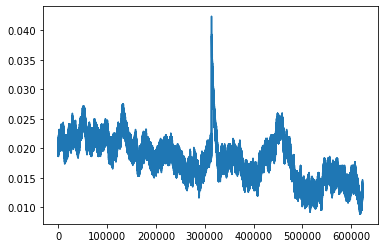

In [7]:
import matplotlib.pyplot as plt
data_wav = raw.pick_channels(['MISC004']).get_data()
plt.plot(data_wav[0])


In [6]:
data_wav[0].shape

(623000,)

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')

plot_matches(seq0, seq1)
plt.plot(data_stim)

In [ ]:
# Put into a csv file both arrays that were used for matching
np.save(f'saves/word_triggers_{subject}_{run_id}.npy', word_triggers[:, 0])
np.save(f'saves/words_start_{subject}_{run_id}.npy', (words.start * 1000).tolist())
# save datastim
np.save(f'saves/data_stim_{subject}_{run_id}.npy', data_stim)


In [ ]:
# Plot the raw data
import matplotlib
matplotlib.use('Qt5Agg')

raw.pick_types(stim=True, misc=True).plot(block=True, start=0, duration=10., precompute='auto')

In [ ]:
raw.first_samp

In [ ]:
import matplotlib.pyplot as plt
plt.plot((words.start * 1000).tolist())

In [ ]:
plt.plot(word_triggers[:, 0])

# Testing JR alignment

Trying to use the alignment method done by JR to show that the decoding works better! 

In [ ]:
# Grabbing the wrong indices:

wrongs = {}

wrongs['5'] = {}

wrongs['5']['3'] = {'events' :759, 'triggers': 804}

wrongs['5']['4'] = {'events' :974, 'triggers': 1061}

wrongs['5']['9'] = {'events' :630, 'triggers': 670}

In [ ]:
error_events = []
error_triggers = []
for subject in wrongs.keys():
    for run in wrongs[subject].keys():
        run_id = '0' + str(run)
        subject = str(subject)
        word_triggers, meta = get_triggers(subject, run_id)
        id_trigger = wrongs[subject][run]['triggers']
        id_events = wrongs[subject][run]['events']
        
        # Get an array around the problematic indexes
        window = 10
        trigger_array = word_triggers[id_trigger - window:id_trigger + window][:,0]
        events_array = np.array(meta.iloc[id_events - window:id_events + window].start * 1000)
        
        error_events.append(events_array)
        error_triggers.append(trigger_array)

In [ ]:
error_events

In [ ]:
error_triggers

In [ ]:
def get_triggers(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Remove the empty words:

    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    return triggers[triggers[:, 2] > 1], meta

In [ ]:
import mne
import logging
import mne_bids
import pandas as pd
import numpy as np
from scipy.io import wavfile

from jr_utils import Align, resample_safe
from utils import match_list

from pathlib import Path
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)


# General epoching function
alignment = True

run_id = '01'
subject = '4'

#path = Path("/home/co/data/neuralset/LPP_copy/pallierlisten2023/download")
path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

def testing(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Remove the empty words:

    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]
    try:
        i, j = approx_match_samples((words.start * 1000).tolist()[:], word_triggers[:, 0], tol=50, max_missing=3)
        return f"Worked for {subject} {run_id}, {len(i) / words.start.shape[0]}"
    except Exception as e:
        # When it doesn't work, print the index where it broke, and create a new file from it
        # To add to the tests
        print(f"Failed for {subject} {run_id}")
        print(f"Error message: {str(e)}")

for subject in range(5,6):
    for run in range(1,10):
        run_id = '0' + str(run)
        subject = str(subject)
        print(testing(subject, run_id))


In [ ]:
# Testing

for subject in range(5,6):
    for run in range(1,10):
        run_id = '0' + str(run)
        subject = str(subject)
        print(testing(subject, run_id))

In [ ]:
# 

for subject in range(21,25):
    for run in range(6,9):
        run_id = '0' + str(run)
        subject = str(subject)
        print(testing(subject, run_id))

In [ ]:
i, j = approx_match_samples((words.start * 1000).tolist()[:], word_triggers[:, 0], tol=10)


In [ ]:
np.diff((words.start * 1000))[:50]

In [ ]:
np.to_csv(, "test.csv")
words_times = words.start * 1000
np.savetxt('words_times.csv', words_times, delimiter=',')

In [ ]:
    import mne
    import logging
    import mne_bids
    import pandas as pd
    import numpy as np
    from scipy.io import wavfile

    from jr_utils import Align, resample_safe
    from utils import match_list

    from pathlib import Path
    # Set the logger level to WARNING to reduce verbosity
    logger = logging.getLogger('mne')
    logger.setLevel(logging.ERROR)


    # General epoching function
    alignment = True

    run_id = '01'
    subject = '3'

    path = Path("/home/co/data/neuralset/LPP_copy/pallierlisten2023/download")

    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Remove the empty words:

    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]

    # Testing the JR alignment

    if alignment:
        starts = mne.find_events(raw, output='step', shortest_event=1)[:, 0]
        meg_times = np.copy(raw.times)
        meg_triggers = np.zeros_like(meg_times)
        meg_triggers[starts - raw.first_samp] = 1

        # read wav
        path_wav = path / 'sourcedata/stimuli/audio/ch1-3.wav'
        wav_freq, wav = wavfile.read(path_wav)
        wav = wav[:, 1] / wav.max()
        # -- decim to get down to meg frequency
        wav_triggers = resample_safe(wav, int(len(wav)/wav_freq*raw.info['sfreq']))

        # -- get events
        wav_times = np.cumsum(np.ones(len(wav_triggers)))/wav_freq
        # fit alignment
        align = Align(freq=raw.info['sfreq'], decim=100)
        inds = np.where(np.diff(wav_triggers) > 0)[0] + 1
        wav_spikes = 0 * wav_triggers
        wav_spikes[inds] = 1
        n = min(len(wav_spikes), len(meg_triggers))
        align.fit(wav_spikes[:n], meg_triggers[:n])
        out = align.predict(wav_spikes)

    # Now that we have the out object, which represents the shifted triggers in the corrected frequency space
    # We can finally realign it with the metdata starts, after diving by sfreq.

    # Transform the current out object to make it like the triggers one, in order to be able 
    # To match on the timing diffs

    # Handle the fact that the triggers are multiple values eg. [0 0 0 1 1 1 0 0 0 0 0 0 1 1 1  0 0 0]
    #unique_vals, counts = np.unique(wav_triggers, return_counts=True)
    #(array([0.        , 0.91555528]), array([602472,  11045]))

    trigger_value = np.unique(out)[1]
    aligned_trigger_indices = np.where(np.diff(out) == trigger_value)[0] + 1


    # Matching triggers and metadata
    decimals = 2
    triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
    events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
    i, j = match_list(triggers_delta, events_delta)

    print(f"Found {len(i)/len(words)} of the words in the triggers")


In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
plt.plot(align._corr)

In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
plt.plot(meg_triggers)
plt.plot(-out)

In [ ]:
wav_spikes

In [ ]:
np.diff(np.where(wav_spikes)[0][:8]) , np.diff(np.where(meg_triggers)[0][:10]), np.diff(np.where(out)[0][:8])

In [ ]:
len(np.where(wav_triggers)[0])

In [ ]:
raw.last_samp

In [ ]:
aligned_trigger_indices.index

In [ ]:
# Matching triggers and metadata
decimals = 2
triggers_delta = np.round(np.diff(aligned_trigger_indices / raw.info["sfreq"]), decimals=decimals)  # type: ignore
events_delta = np.round(np.diff(meg_triggers), decimals=decimals)  # type: ignore
i, j = match_list(triggers_delta, events_delta)

print(f"Found {len(i)/len(words)} of the words in the triggers")


In [ ]:
%matplotlib qt

In [ ]:
np.unique(out)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(raw)

In [ ]:
word_triggers[-1][0] - word_triggers[0][0]

In [ ]:
aligned_trigger_indices[-1] - aligned_trigger_indices[0]

In [ ]:
align._stretch

In [ ]:
align._offset

In [ ]:
(aligned_trigger_indices)

In [ ]:
trigger_value = np.unique(out)[1]
aligned_trigger_indices = np.where(np.diff(out) == trigger_value)[0] + 1


In [ ]:
raw.first_samp

In [ ]:
triggers

In [ ]:
17890 + 28000

In [ ]:
aligned_trigger_indices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a numpy array of the downsampled audio signal
    
# Create a numpy array of the time axis for the downsampled signal
downsampled_time = np.arange(len(signal)) / 1000

# Create a numpy array of the time axis for the original signal
original_time = np.arange(len(signal) * 44) / 44100

# Use interpolation to upsample the downsampled signal to the original sampling rate
upsampled_signal = np.interp(original_time, downsampled_time, signal)

# Plot the downsampled and upsampled signals
plt.plot(original_time, upsampled_signal, label='Upsampled signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
true_indices = words.iloc[j].index

mask = events_df.index.isin(true_indices)

# Set the start column for the selected rows
events_df.loc[mask, "start"] = (
    aligned_trigger_indices[i] / raw.info["sfreq"]
)

# Drop the rows that don't match the indices in true_indices
events_df = events_df.loc[mask]

In [ ]:
events_df = events_df.sort_values(by="start").reset_index(drop=True)


In [ ]:
events_df

# Text Grid testing

Testing the timings & nb of triggers in the original TextGrid file that was used to generate metadata / triggers in the wav file.

In [ ]:
import textgrids as tg
import pandas as pd


files = [f'/home/co/tmp/testing_code/{i}.TextGrid' for i in range(1,4)]

all_starts = []
grid_starts = []
grid_word_count = []

for file in files:
    textgrid = tg.TextGrid(file)
    words = [interval.text for interval in (textgrid['text words']) if interval.text != ""]
    starts = [interval.xmin for interval in (textgrid['text words']) if interval.text != ""]
    all_starts.append(starts)
    grid_word_count.append(len(words))
    
    first_pause = textgrid['text words'][0].xmax
    grid_starts.append(first_pause)
    
grid_length = [starts[-1] - starts[0] for starts in all_starts]

for i in range(len(grid_length)):
    print(f'For run {i+1}')
    print(f'Word count: {grid_word_count[i]}')
    print(f'Grids word length from Praat textgrids: {grid_length[i]} ') 
    print(f'Grid start from audio start to first word: {grid_starts[i]} ') 


# Wav File testing

Now testing the amount of triggers in the wav file, as well as its real length (as used in the MEG).

In [ ]:
import numpy as np 
from scipy.io import wavfile
import matplotlib.pyplot as plt

CHAPTER_PATHS = [
    "ch1-3.wav",
    "ch4-6.wav",
    "ch7-9.wav",
    "ch10-12.wav",
    "ch13-14.wav",
    "ch15-19.wav",
    "ch20-22.wav",
    "ch23-25.wav",
    "ch26-27.wav",
]

audio_word_trigger_length = []
audio_trigger_length = []

for i, chapter in enumerate(CHAPTER_PATHS):
    wav_file = f'/home/co/data/neuralset/LPP_copy/PallierListen2023/download/sourcedata/stimuli/audio/{chapter}'
    duration = get_wav_duration(wav_file)
    fs, data = wavfile.read(wav_file)

    # Getting the channel for the triggers encoded in the 2nd part of the wav
    data = data[:,1]
    data = np.round(data / 30000)
    diff = np.diff(data)
    audio_triggers = np.where(diff == 1)[0]
    word_total_length =  (audio_triggers[-1] - audio_triggers[0] )/ fs
    
    audio_word_trigger_length.append(word_total_length)
    audio_trigger_length.append(duration)
    print(f'For run: {i+1}')
    print(f'Word count:' , len(audio_triggers))
    print("Length of word triggers in the audio file : ", word_total_length)
    print("TOTAL Length of the audio file : ", duration)
    print(f'Wav start from audio start to first word: {audio_triggers[0] / fs} ') 

    

# Metadata testing

There is an inherent problem that I could fix with the metadata. In the textgrid, there is a weird jump with du (it is always followed by an empty event "").

I added it to the metadata, but it is not present in the triggers. It means a difference of ~40 words that are missed when matching on metadata with triggers. 

I fixed it by removing empty words when reading the event file.

In [ ]:
path = "/home/co/data/LPP_MEG_auditory/sub-1/ses-01/meg/sub-1_ses-01_task-listen_run-"

for run in range(1,10):
    file = path + f'0{run}_events.tsv'
    meta = pd.read_csv(file, sep='\t')
    meta['start'] = meta.onset
    
    # Trying to remove the additional empty word
    
    meta_triggers = meta.start
    print(f'For run {run}')
    print(f'Word count: {meta.shape[0]}')
    print(f'Meta length from metadata file: {(meta_triggers.iloc[-1] - meta_triggers.iloc[0])} ') 
    print(f'Metadata start from audio start to first word: {meta_triggers[0]} ') 

# Triggers testing

In [ ]:
# Two events in STI001
# Start of sound, first trigger STI008613.5172789115646
# Verify buffer over/under run
# Instller JACK driver audio PC MEG?

# Timing photodiode theorique PallierRead

In [ ]:
import mne
import logging
import mne_bids
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)

subject = '2'

all_triggers = []  # All the trigger timings
all_word_triggers = []  # All the word triggers
trigger_starts = []  # The time of between first trigger (beginning of audio) and first word
triggers_word_count = []  # The total number of word triggers for each run
all_word_trigger_length = []  # The total length from the first word trigger to the last one
all_trigger_length = []  # The total length from the first trigger to the last one (the whole audio file)

for run in range(1,10):
    run_id = '0'+ str(run)
    # Audio data
    
    audio_data = get_audio_timestamps(subject, run_id)
    
    # Triggers words
    f, triggers = get_triggers(subject, run_id)
    all_triggers.append(triggers)
    
    word_triggers = triggers[triggers[:, 2] > 1][:,0]
    all_word_triggers.append(word_triggers)
    
    first_diff = (triggers[1][0] - triggers[0][0]) / f
    trigger_starts.append(first_diff)
    
    triggers_word_count.append(word_triggers.shape[0])
    
    word_trigger_length = (word_triggers[-1] - word_triggers[0]) / f
    all_word_trigger_length.append(word_trigger_length)
    
    total_length = triggers[-1][0] - triggers[0][0]
    all_trigger_length.append(total_length)
        
for i in range(len(all_word_trigger_length)):
    print(f'For run {i}')
    print(f'Number of word triggers: {triggers_word_count[i]} ') 
    print(f'Trigger start from audio start to first word: {trigger_starts[i]} ') 
    print(f'Total length of words triggers: {all_word_trigger_length[i]}')
    print(f'Total length from first triger to the last: {all_trigger_length[i] / f}')

# Comparaisons

Let's compare the difference between the trigger length recorded vs theoritical, between runs / subjects

In [ ]:
timing_diff = [all_word_trigger_length[run] - audio_word_trigger_length[run] for run in range(9)]

plt.plot(timing_diff)

Trying to generate an explicit array, that contains matched words, unmatched, with the indidces from words and triggers

In [ ]:
run_id = '01'
subject = '3'

path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

task = 'listen'
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
# triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

meta = pd.read_csv(event_file, sep="\t")

meta["word"] = meta["trial_type"].apply(
        lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

# Remove the empty words:

meta.loc[meta['word'] == ' ', 'word'] = None

# Drop the rows containing NaN values in the text column
meta = meta.dropna(subset=['word'])

meta['start'] = meta.onset

words = meta

events_df = meta
# Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
word_triggers = triggers[triggers[:, 2] > 1]


# Matching triggers and metadata


decimals = 2
triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
i, j = match_list(triggers_delta, events_delta)

print(f"Found {len(i)/len(words)} of the words in the triggers")


In [ ]:
# Building a complete array to understand whats going on before / after match list

current_i = -1
current_j = -1

list_events = []
for i_, j_ in zip(i, j):  # Make sure that 'i' and 'j' iterables are defined before this line
    for m_i in range(current_i + 1, i_):
        list_events.append({"data": "trigger", "trigger_ind": m_i, "trigger_time": word_triggers[m_i][0]/ raw.info['sfreq']})
        
    for m_j in range(current_j + 1, j_):
        list_events.append({"data": "word", "word": words.word.iloc[m_j], "word_time": words.onset.iloc[m_j], "word_duration": words.duration.iloc[m_j]})
    list_events.append({"data": "match", "trigger_ind": i_, "word_ind":words.index[j_], "word": words.word.iloc[j_], "trigger_time": word_triggers[i_][0] / raw.info['sfreq'], "word_time": words.onset.iloc[j_], "word_duration": words.duration.iloc[j_]})
    current_i = i_
    current_j = j_
    


In [ ]:
df_events = pd.DataFrame(list_events)
df_events = df_events.loc[:, sorted(df_events.columns)]
df_events.to_csv('./df_events.csv', sep = ",")

In [ ]:
# Find 5 words for which we know it is the end of a sentence,and confirm their timings !

targets = []

audio_start = 4724  # Find the audio start in the wav file extracted, from the wave form

timings = [1601, 1611, 1621, 1622, 1628, 1629, 1630]  # Gravement, (chez) moi: 605328,  ajouta, droit: 610390: pas aller bien 
# Le petit prince remarqua gravement: word_ind 1601

for timing in timings:
    target = df_events.loc[df_events.word_ind == timing].trigger_time.values[0]
    targets.append(target*raw.info['sfreq'])

diff_moi = (df_events.loc[df_events.word_ind == 1611].trigger_time.values[0] * 1000 )- 605328
diff_droit =( df_events.loc[df_events.word_ind == 1622].trigger_time.values[0] * 1000) - 610390

In [ ]:
diff_moi, diff_droit

In [ ]:
audio_length = 612660
audio_length - audio_start

In [ ]:
df_events.trigger_time.iloc[-1] - df_events.trigger_time.iloc[0]

In [ ]:
df_events.head(10)

In [ ]:

df_events[-50:]

In [ ]:
df_events.to_csv('./df_events.csv', sep = ",")

## Analyzing the MEG recorded wav file, to see if it aligns with the matched data timings

In [ ]:
file = '/home/co/Downloads/petitprince-sub6.npy'

import numpy as np 
import matplotlib.pyplot as plt

data = np.load(file)


In [ ]:
first_word

In [ ]:
first_word = df_events.trigger_time[:1].values[0] * 1000

for target in targets:
    epsilon = 200  # Go slightly before the event to make sure the audio starts after epsilon time
    inf_ = target - first_word + audio_start
    sup_ = 0
    plt.figure()
    plt.plot(data[int(inf_):])

In [ ]:
inf_

In [ ]:
data.shape

In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
plt.plot(data[inf_:])

# Subject analysis


In [ ]:
# Loading the pre-computed array of results, no need to reload every raw file

# Load the NumPy array from a file in binary format
arr = np.load('results.npy', allow_pickle=True)

# Convert the NumPy array to a list of dictionaries
rst = arr.tolist()


In [ ]:
plot_timing_diff(rst[:10], 'word')

In [ ]:
plot_timing_diff(all_results[:10], 'audio')

In [ ]:
# Sub 1 seems to have no shift.. let's investigate

sub1_data = all_results[0]

sub1_run1_audio_length = sub1_data['all_triggers'][0][-1][0] - sub1_data['all_triggers'][0][0][0]

sub1_run1_words_length = sub1_data['all_word_triggers'][0][-1] - sub1_data['all_word_triggers'][0][0]

# Solution

We could try to, for each subject, each run, find the linear shift and apply it to the metadata: we align the first trigger (start in STI001), and then apply the metadata starts * modified sfreq.

To do so, we need to study first if for each subject, the shift throughout the run is always linear.

Then, for one subject, through runs.

## Studying the shift through subject for run 1

In [ ]:
import matplotlib.pyplot as plt

for subject in range(1, 58):
    subject = str(subject)

    # Create a new figure object and set it as the current figure
    plt.figure()

    # Plot the data for the current subject
    diff, prec = get_trigger_diff_array(subject=subject)
    plt.plot(diff)
    plt.title(f"{subject}_prec_{prec}")
    # Save the figure to a file
    plt.savefig(f'./figures/{subject}.png')


# Decoding attempts

In [ ]:
from dataset import populate_metadata_epochs

In [ ]:
subject = '19'
decoding_criterion = 'wlength'
level = 'word'
start = 'onset'
modality = "auditory"

epochs = populate_metadata_epochs(modality,
    subject,
    level,
    start,
    runs=1,
    decoding_criterion=decoding_criterion)



In [ ]:
all_scores = []

# decoding word emb
print("loading data")
epochs = epochs.pick_types(meg=True, stim=False, misc=False).load_data()
X = epochs.get_data()
print("data loaded")



In [ ]:
X = epochs.get_data()

In [ ]:
y = epochs.metadata.wlength
R_vec = decod_xy(X, y)
scores = R_vec

for t, score in enumerate(scores):
    all_scores.append(
        dict(
            subject=subject,
            score=score,
            t=epochs.times[t],
        )
    )

# Functions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from Levenshtein import editops
import string

def decod_xy(X, y):
    """
    Simple decoding function to evaluate how much
    information can be infered from X to predict y.
    Training a RidgeCV and then calculating the
    Pearson R between predicted and test y
    Args:
        - X: np.Array
        - y: np.Array
    Returns:
        - np.Array
    """
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 8, 10)))
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0], 1)
    R = np.zeros((n_times, y.shape[1]))

    for t in range(n_times):
        print(".", end="")
        rs = []
        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        for train, test in cv.split(X):
            model.fit(X[train, :, t], y[train])
            y_pred = model.predict(X[test, :, t])
            r = correlate(y[test], y_pred)
            rs.append(r)
        R[t] = np.mean(rs)
        # R[t] = correlate(y, y_pred)

    return R



In [ ]:
from pathlib import Path
import mne_bids
import mne

import pandas as pd
from utils import match_list


#path = '/home/co/data/LPP_MEG_auditory'
path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")


def get_trigger_diff_array(subject):
    run_id = '01'
    path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Trying to remove the empty words:
    
    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]


    # Matching triggers and metadata


    decimals = 2
    triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
    events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
    i, j = match_list(triggers_delta, events_delta)

    print(f"Found {len(i)/len(words)} of the words in the triggers")

    true_indices = words.iloc[j].index

    # Find the missing words df
    opposite_indices = events_df.index.difference(true_indices)
    opposite_events_df = events_df.loc[opposite_indices]


    events_df = events_df.loc[true_indices].copy()

    events_df.loc[true_indices, "start"] = (
        word_triggers[i, 0] / raw.info["sfreq"]
    )


    # Match on text the events_df df with the initial metadata, to have info how it shifts

    metadata_words = meta
    matched_words = events_df

    # Match list between the two events arrays
    idx2, idx = match_list((metadata_words.word.values), (matched_words.word.values))

    # Return the diff arrays
    diff_array = metadata_words.start.values[idx2] - matched_words.start.values[idx]
    return diff_array, len(i)/len(words)

def get_triggers(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    sfreq = raw.info['sfreq']
    
    return sfreq, triggers

def get_audio_timestamps(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    audio_data = raw.get_data(picks=["MISC004"])[0,:]

    sfreq = raw.info['sfreq']
    
    return sfreq, audio_data

def get_raw(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    return raw


import wave

def get_wav_duration(filename):
    with wave.open(filename, 'rb') as wav_file:
        # Get the total number of frames in the WAV file
        frames = wav_file.getnframes()
        
        # Get the frame rate (number of frames per second)
        frame_rate = wav_file.getframerate()
        
        # Calculate the duration in seconds
        duration = frames / float(frame_rate)
        
        return duration
    
    import matplotlib.pyplot as plt

def plot_timing_diff(all_results, target):
    num_subjects = len(all_results)
    num_runs = 9

    # Create an empty list to store the timing differences for all subjects and runs
    timing_diffs = [[] for _ in range(num_subjects)]

    # Loop over all subjects and runs
    for subject_idx, subject_results in enumerate(all_results):
        for run in range(1, num_runs + 1):
            
            if target == 'word':
                # Extract the word trigger length and audio word trigger length for the current run
                word_trigger_length = subject_results['all_word_trigger_length'][run - 1]
                audio_word_trigger_length_ = audio_word_trigger_length[run - 1]

                # Calculate the timing difference
                timing_diff_ = word_trigger_length - audio_word_trigger_length_

            if target == 'audio':
                audio_trigger_length_meg = subject_results['all_trigger_length'][run - 1]
                audio_trigger_length_ = audio_trigger_length[run - 1]

                # Calculate the timing difference
                timing_diff_ = (audio_trigger_length_meg / 1000) - audio_trigger_length_
                
                
            timing_diffs[subject_idx].append(timing_diff_)
            
            
    # Loop over all subjects and plot the timing differences for each run
    for subject_idx, timing_diff in enumerate(timing_diffs):
        plt.plot(range(1, num_runs + 1), timing_diff, label=f'Subject {subject_idx + 1}')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('Run')
    plt.ylabel(f'Timing difference for {target}(s)')
    plt.show()



In [ ]:
import mne
import logging
import mne_bids
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)


all_results = []

for subject in range(1,20):
    subject = str(subject)
    all_triggers = []  # All the trigger timings
    all_word_triggers = []  # All the word triggers
    trigger_starts = []  # The time of between first trigger (beginning of audio) and first word
    triggers_word_count = []  # The total number of word triggers for each run
    all_word_trigger_length = []  # The total length from the first word trigger to the last one
    all_trigger_length = []  # The total length from the first trigger to the last one (the whole audio file)

    subject_results = {}  # Create an empty dictionary for the subject results
    
    for run in range(1,10):
        run_id = '0'+ str(run)

        # Triggers words
        f, triggers = get_triggers(subject, run_id)
        all_triggers.append(triggers)

        word_triggers = triggers[triggers[:, 2] > 1][:,0]
        all_word_triggers.append(word_triggers)

        first_diff = (triggers[1][0] - triggers[0][0]) / f
        trigger_starts.append(first_diff)

        triggers_word_count.append(word_triggers.shape[0])

        word_trigger_length = (word_triggers[-1] - word_triggers[0]) / f
        all_word_trigger_length.append(word_trigger_length)

        total_length = triggers[-1][0] - triggers[0][0]
        all_trigger_length.append(total_length)

    # Add the results to the subject dictionary
    subject_results['all_triggers'] = all_triggers
    subject_results['all_word_triggers'] = all_word_triggers
    subject_results['trigger_starts'] = trigger_starts
    subject_results['triggers_word_count'] = triggers_word_count
    subject_results['all_word_trigger_length'] = all_word_trigger_length
    subject_results['all_trigger_length'] = all_trigger_length

    all_results.append(subject_results)
